# COGS 108 - Final Project

## Important

- ONE, and only one, member of your group should upload this notebook to TritonED. 
- Each member of the group will receive the same grade on this assignment. 
- Keep the file name the same: submit the file 'FinalProject.ipynb'.
- Only upload the .ipynb file to TED, do not upload any associted data. Make sure that for cells in which you want graders to see output that these cells have been executed.

## Group Members: Fill in the Student IDs of each group member here

Replace the lines below to list each persons full student ID, ucsd email and full name.

- A12814729, vkhua@ucsd.edu, Vivian Hua
- A11983710, css003@ucsd.edu, Cody Sophearum Smith
- U07979059, ddjiang@ucsd.edu, Derek De Gui Jiang
- A13497348, allacuna@ucsd.edu, Allyson Llacuna
- A12433857, Jor029@ucsd.edu, Joel Ramirez
- A11774341, dkovelma@ucsd.edu, Daniel Kovelman-Ottilie



Start your project here.

## Introduction and Background

The purpose of this project is to determine how do different regional factors influence unemployment rate in addition to attempting to come up with an equation that could predict unemployment rate using strongly correlated facotrs. All correlations used for the formation of the unemployment rate prediction equation will be derived from a dataset containing various information from several different Wal-Mart stores within the U.S. Wal-Mart data specfically will be used for the purposes of this project because Wal-Mart, as the "largest private sector employer in the US," is often a "lightning rod for criticism" concerning issues of worker compensation, pay, and employment (1). In addition to being the largest private employer, research has also shown that Wal-Mart is so huge in the United States that there can even be implications for regional unemployment rates when a Wal-Mart moves into an area (2). Therefore, any correlations that can be found might be applicable and useful to other popular corporations wanting to open up another store in a specific area.


Based upson some findings on the relationship of unemployment rate to inflation(3) and to changes in gas prices(4), We resonably hypothesized that factors such as comsumer price index (CPI), fuel price, and weekly sales will correlate strongly with unemployment rate with a negative, postive, and negative correlation respectively. Therefore, these will be the factors that will be included in the overall unemployment rate prediction equation. In addition, we hypothesized that other factors, such as average regional temerpature and holidays, would have a weak correlation with unemployment rate over time and will be dropped from the overall prediction equation due to negligble effects on unemployment.

References (include links):
- 1) Bhattarai, Abha, and Todd C. Frankel. "Walmart Said It's Giving Its Employees A Raise. And Then It Closed 63 Stores." The Washington Post, 11 Jan. 2018, https://www.washingtonpost.com/news/business/wp/2018/01/11/walmart-to-raise-starting-hourly-wage-to-11-offer-paid-parental-leave/?fbclid=IwAR1L5UfHBA78aJ-vkee9tJZsBCpDlQyedVMNBrzrwdORjHCS-rz_LP1KMKk&noredirect=on&utm_term=.d01ffabc9bfa

- 2) Keil, Stanley R. and Lee C. Spector. "The Impact of Wal-Mart On Income And Unemployment Differentials In Alabama." The Review of Regional Studies 35.3 (2005): 336-355. Web. 16 Feb. 2019 https://pdfs.semanticscholar.org/1650/e455a3185c4b257b7b30c971c1606562ac31.pdf?fbclid=IwAR0ECEpANJRWRqDiftbjiqrdp_FseDbt2LIY4uzjM5pzgfi8TF-kwiGBPdk 

- 3) Picardo, Elvis. "How Inflation and Unemployment Rate Are Related." Investopedia, 11 May 2018, https://www.investopedia.com/articles/markets/081515/how-inflation-and-unemployment-are-related.asp

- 4) "The Price Of Gas And The Unemployment Rate." Seeking Alpha, 14 Feb. 2011, https://seekingalpha.com/article/252704-the-price-of-gas-and-the-unemployment-rate?page=2&fbclid=IwAR2t9FILcjgUuubDZ8fAUdEhVRoc0ILlh35LnpJ4vRC7b5ar8e796JMWzMk

- 5) Taylor, Kate. "The Unemployment Rate Has Fallen To A 48-Year Low, And It's Terrifying News For Walmart, McDonald's, And JCPenney." Business Insider, 5 Oct. 2018, https://www.businessinsider.com/unemployment-rate-sparks-hiring-concerns-2018-10?fbclid=IwAR2PW52Drh-x60tGPTKNiZauPHMSwv9qjAQqdLWDlkW06uDcsgoxOUGvB3w

## Data Description

[Read the Kaggle, describe it based on that, and tie it in with how the data will/won't be used for our projects]

In [1]:
#The imports for this project
import pandas as pd
import numpy as np
import seaborn as sp
import matplotlib as mplot
from collections import defaultdict
from scipy import stats
import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest
from sklearn import preprocessing

## Data Cleaning

There are a few jobs to do to make the data usable for the types of analysis we desire. Since the datasets were made with a particular cause in mind, not all the data is relevant, as well as some of the observations are missing certain key data or are in a datatype not conducive to our analysis. 
To clean the data, we first remove columns not relevant to our analysis. The columns named Markdown 1-5 in features.csv will not be used in the analysis. To aid the analysis, we want all the relevant data in one dataset, and we want to use the weekly sales information from train.csv. The issue with train.csv is that not only are the observations split across store and date as with features.csv, but also across department. In order to add them to features, we first sum the weekly sales for each department on the same date in the same store, then we add that total weekly sales to the features dataset on store and date. Once that is accomplished, we change the data in the "Date" column to be an integer instead of a string for plotting and analysis convenience. Lastly, we remove rows with missing unemployment data and check for outliers.

In [2]:
weeksalesdb = pd.read_csv('train.csv')
stores = pd.read_csv('stores.csv' , dtype = {'Store': int})
features = pd.read_csv('features.csv')

In [3]:
features.drop(columns = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5'], inplace = True)

In [4]:
#converts weeksalesdb rows into dict and merging departments
agg_sales = defaultdict(int)
for ind, sale in weeksalesdb.iterrows():
    agg_sales[str(sale['Store'])+'.'+sale['Date']] += sale['Weekly_Sales']

In [5]:
#converts back into db with updated sales value
storesales = pd.DataFrame(columns=['Store','Date','Weekly_Sales'])

for key, value in agg_sales.items():
    store, date = key.split('.')
    newrow = [store, date, value]
    storesales.loc[len(storesales)] = newrow

In [6]:
#function to convert date to integer
def convert_date(date):
    date = date.strip()
    date = date.replace('-','')
    date = date.strip()
    return int(date)

#convert date columns
storesales['Date'] = storesales['Date'].apply(convert_date)
features['Date'] = features['Date'].apply(convert_date)

In [7]:
#convert store column to int (was str)
storesales['Store'] = pd.to_numeric(storesales['Store'])
features.head(10)

,Store,Date,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,20100205,42.31,2.572,211.096358,8.106,False
1,1,20100212,38.51,2.548,211.242170,8.106,True
2,1,20100219,39.93,2.514,211.289143,8.106,False
3,1,20100226,46.63,2.561,211.319643,8.106,False
4,1,20100305,46.50,2.625,211.350143,8.106,False
5,1,20100312,57.79,2.667,211.380643,8.106,False
6,1,20100319,54.58,2.720,211.215635,8.106,False
7,1,20100326,51.45,2.732,211.018042,8.106,False
8,1,20100402,62.27,2.719,210.820450,7.808,False
9,1,20100409,65.86,2.770,210.622857,7.808,False


In [8]:
#exported csv files
storesales.to_csv('storesales.csv')
features.to_csv('features2.csv')

In [9]:
#merged two dataframes together on the store and date column
merged = pd.merge(storesales, features, on =['Store', 'Date'], how = 'outer')

In [10]:
#removed rows where unemployment data was empty
merged.dropna(subset = ['Unemployment'], inplace = True)

In [11]:
#export cleaned features
#merged.to_csv('features_clean.csv', index = False)

In [12]:
merged.head(10)

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,20100205,1643690.90,42.31,2.572,211.096358,8.106,False
1,1,20100212,1641957.44,38.51,2.548,211.242170,8.106,True
2,1,20100219,1611968.17,39.93,2.514,211.289143,8.106,False
3,1,20100226,1409727.59,46.63,2.561,211.319643,8.106,False
4,1,20100305,1554806.68,46.50,2.625,211.350143,8.106,False
5,1,20100312,1439541.59,57.79,2.667,211.380643,8.106,False
6,1,20100319,1472515.79,54.58,2.720,211.215635,8.106,False
7,1,20100326,1404429.92,51.45,2.732,211.018042,8.106,False
8,1,20100402,1594968.28,62.27,2.719,210.820450,7.808,False
9,1,20100409,1545418.53,65.86,2.770,210.622857,7.808,False


In [13]:
#checked for outliers in the weekly sales column, most of these are on or near holidays.
outliers = merged[merged['Weekly_Sales'] > merged['Weekly_Sales'].mean() + 3 * merged['Weekly_Sales'].std()]
outliers

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
189,2,20101224,3436007.68,49.97,2.886,211.064660,8.163,False
241,2,20111223,3224369.80,46.66,3.112,218.999550,7.441,False
471,4,20101126,2789469.45,48.08,2.752,126.669267,7.127,True
475,4,20101224,3526713.39,43.21,2.887,126.983581,7.127,False
523,4,20111125,3004702.33,47.96,3.225,129.836400,5.143,True
526,4,20111216,2771397.17,36.44,3.149,129.898065,5.143,False
527,4,20111223,3676388.98,35.92,3.103,129.984548,5.143,False
1329,10,20101126,2939946.38,55.33,3.162,126.669267,9.003,True
1332,10,20101217,2811646.85,59.15,3.125,126.879484,9.003,False
1333,10,20101224,3749057.69,57.06,3.236,126.983581,9.003,False


In [14]:
features = pd.read_csv('features_clean.csv')

## Data Visualization

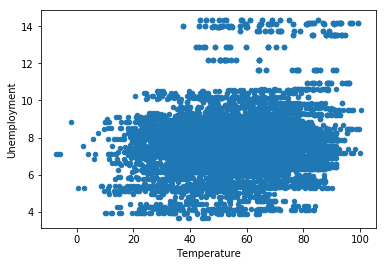

In [15]:
features.plot.scatter(x='Temperature', y='Unemployment')

Text(0, 0.5, 'Unemployment')

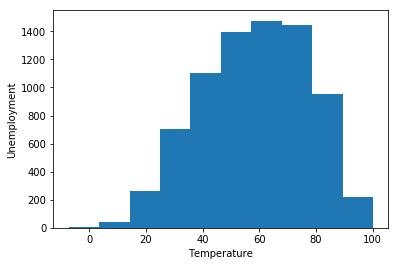

In [29]:
features['Temperature'].plot.hist()
mplot.pyplot.xlabel('Temperature')
mplot.pyplot.ylabel('Unemployment')

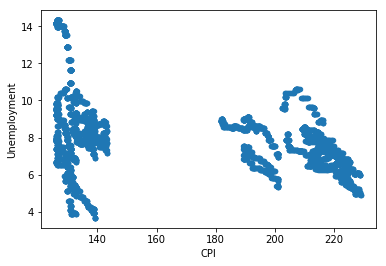

In [30]:
features.plot.scatter(x='CPI', y='Unemployment')

Text(0, 0.5, 'Unemployment')

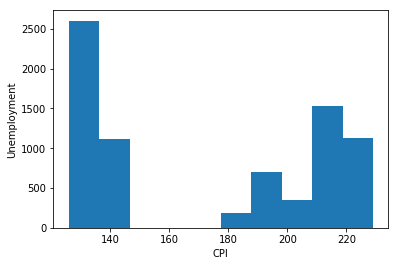

In [31]:
features['CPI'].plot.hist()
mplot.pyplot.xlabel('CPI')
mplot.pyplot.ylabel('Unemployment')

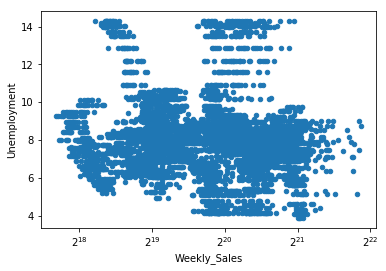

In [32]:
features.plot.scatter(x='Weekly_Sales', y='Unemployment')
# Convert large values into log base 2 for easier data visualization
# Weekly_sales is measured in dollars
mplot.pyplot.xscale('log', basex=2)

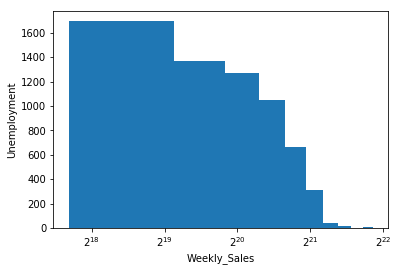

In [33]:
features['Weekly_Sales'].plot.hist()
mplot.pyplot.xlabel('Weekly_Sales')
mplot.pyplot.ylabel('Unemployment')
mplot.pyplot.xscale('log', basex=2)

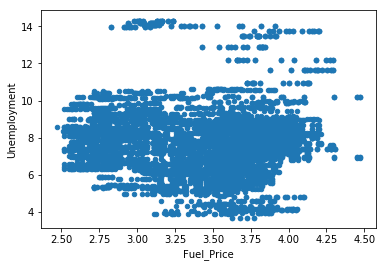

In [34]:
features.plot.scatter(x='Fuel_Price', y='Unemployment')

Text(0, 0.5, 'Unemployment')

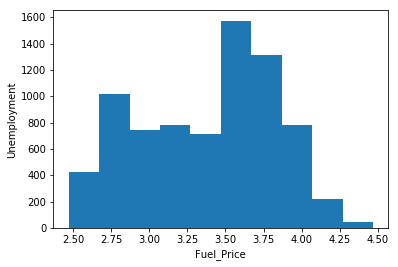

In [35]:
features['Fuel_Price'].plot.hist()
mplot.pyplot.xlabel('Fuel_Price')
mplot.pyplot.ylabel('Unemployment')

## Data Analysis and Results

<font size="4">Here, we will be analyzing how much each factor influences unemployment before developing a model.</font>

In [17]:
out_sales, pred_sales = patsy.dmatrices('Unemployment ~ Weekly_Sales', features)
mod_sales = sm.OLS(out_sales, pred_sales)
res_sales = mod_sales.fit()

out_temp, pred_temp = patsy.dmatrices('Unemployment ~ Temperature', features)
mod_temp = sm.OLS(out_temp, pred_temp)
res_temp = mod_temp.fit()

out_fuel, pred_fuel = patsy.dmatrices('Unemployment ~ Fuel_Price', features)
mod_fuel = sm.OLS(out_fuel, pred_fuel)
res_fuel = mod_fuel.fit()

out_cpi, pred_cpi = patsy.dmatrices('Unemployment ~ CPI', features)
mod_cpi = sm.OLS(out_cpi, pred_cpi)
res_cpi = mod_cpi.fit()

In [18]:
print(res_sales.summary(), res_temp.summary(), res_fuel.summary(), res_cpi.summary())

                            OLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     73.35
Date:                Thu, 21 Mar 2019   Prob (F-statistic):           1.34e-17
Time:                        14:41:50   Log-Likelihood:                -13142.
No. Observations:                6435   AIC:                         2.629e+04
Df Residuals:                    6433   BIC:                         2.630e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        8.3686      0.049    170.751   

<font size="4">After finding which features were most correlated, we attempted to build a model to predict unemployment from a combination of features, first using the ones that appeared most relevant.</font>


In [19]:
out1, pred1 = patsy.dmatrices('Unemployment ~ Weekly_Sales + CPI', features)
mod1 = sm.OLS(out1, pred1)
res1 = mod1.fit()

In [20]:
print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.107
Method:                 Least Squares   F-statistic:                     388.2
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          6.57e-160
Time:                        14:41:50   Log-Likelihood:                -12812.
No. Observations:                6435   AIC:                         2.563e+04
Df Residuals:                    6432   BIC:                         2.565e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       10.9938      0.110    100.023   

<font size="4">To check what happens when all the factors are incorporated, we made an additional model with all the features.</font>

In [21]:
out2, pred2 = patsy.dmatrices('Unemployment ~ Weekly_Sales + CPI + Fuel_Price + Temperature', features)
mod2 = sm.OLS(out2, pred2)
res2 = mod2.fit()

In [22]:
print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     270.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          2.65e-215
Time:                        14:41:50   Log-Likelihood:                -12678.
No. Observations:                6435   AIC:                         2.537e+04
Df Residuals:                    6430   BIC:                         2.540e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       11.9578      0.209     57.213   

<font size="4">The predictive power of the model went up when incorporating the additional features, as well as in the summary all factors are found to be significant (P>|t|). To further investigate the relationship between the features and unemployment, we standardize the data below.</font>

In [23]:
def standardizevalue(self, df, label):
    df = df.copy(deep=True)
    series = df.loc[:, label]
    avg = series.mean()
    stdv = series.std()
    series_standardized = (series - avg)/stdv
    return series_standardized

In [24]:
#columns we want to standardize
numericcolumns = features[['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']]
#get the column names
names = numericcolumns.columns
#create scaler
scaler = preprocessing.StandardScaler()
#apply transformation
normaled = scaler.fit_transform(numericcolumns)
normaled = pd.DataFrame(normaled, columns=names)
#delete the columns to be replaced with new values
features_normal = features.drop(labels = names, axis = 'columns')
#add in the columns from the normalized df
features_normal[names] = normaled
#rearrange columns to be like original features
features_normal = features_normal[features.columns]
#export csv file
features_normal.to_csv('features_normal.csv', index = False)

features_normal

,Store,Date,Weekly_Sales,Temperature,Fuel_Price,CPI,Unemployment,IsHoliday
0,1,20100205,1.057420,-0.854543,-1.852210,0.972312,0.148726,False
1,1,20100212,1.054348,-1.057658,-1.906579,0.975982,0.148726,True
2,1,20100219,1.001206,-0.981757,-1.983601,0.977164,0.148726,False
3,1,20100226,0.642828,-0.623633,-1.877129,0.977932,0.148726,False
4,1,20100305,0.899914,-0.630582,-1.732146,0.978699,0.148726,False
5,1,20100312,0.695660,-0.027117,-1.637001,0.979467,0.148726,False
6,1,20100319,0.754091,-0.198696,-1.516937,0.975314,0.148726,False
7,1,20100326,0.633441,-0.365998,-1.489753,0.970342,0.148726,False
8,1,20100402,0.971082,0.212344,-1.519203,0.965369,-0.010026,False
9,1,20100409,0.883278,0.404235,-1.403669,0.960396,-0.010026,False


In [25]:
out3, pred3 = patsy.dmatrices('Unemployment ~ Weekly_Sales + CPI + Fuel_Price + Temperature', features_normal)
mod3 = sm.OLS(out3, pred3)
res3 = mod3.fit()

In [26]:
print(res3.summary())

                            OLS Regression Results                            
Dep. Variable:           Unemployment   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     270.6
Date:                Thu, 21 Mar 2019   Prob (F-statistic):          2.65e-215
Time:                        14:41:50   Log-Likelihood:                -8625.5
No. Observations:                6435   AIC:                         1.726e+04
Df Residuals:                    6430   BIC:                         1.729e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0531      0.012      4.541   

<font size="4">With standardization, it is clearer to see the impact each feature has on unemployment. CPI is the most strongly correlated, followed (surprisingly) by temperature, then weekly sales, and then fuel price.</font>

## Privacy/Ethics Concerns

As mentioned before, the data about Walmart was founded on Kaggle, a public space where datasets can be accessible to those with the link to that information. Since most of these are being used for competition purposes, the purpose of providing the data was to have anyone analyze it, meaning that the public was free to download the data with no restrictions nor hold additional responsibilities of it. The owner of the data, however, was not provided in Kaggle and makes its credibility questionable. Not knowing who provided the data and how they retrieved such information raises questions such as “how much of the data given was extracted from the original source?” and “how accurate is this information?”

In concern with the actual data, our choice of datasets has not changed since the proposal despite being it anonymized. The data being anonymized was good in the sense that no one’s information such as their name, race, age, etc. affected was presented thereby ensuring no clear biases within the sets. Since no additional datasets were added to the research, the missing information about some factors for each Walmart such as their location had to be assumed by other data information.

## Conclusions and Discussion

In the analysis, we found that all four of the main factors analyzed were significant in predicting unemployment. In line with our hypothesis, CPI, weekly sales, and fuel price did have negative correlations with unemployment rate. Where we were surprised, however, was to find that temperature did have a significant correlation with unemployment in our model, and a positive one, at that. 

Given background research on how CPI and fuel price impact unemployment rate, the results we found are aligned with these findings. Weekly sales intuitively makes sense as with an increase in weekly sales, there would be a higher need for workers as those are busier times for the store, leading to a negative relationship with unemployment. Temperature may have to do with seasonal changes in demand. In the data visualization section, while temperature and unemployment do not appear to have a strong correlation initially, there is a cluster of higher unemployment rates when the temperature is high, which may indicate that unemployment is lower during the colder seasons. This may be due to how certain major holidays that are important for retail stores like Christmas or Thanksgiving are during the colder times of the year. 

Using the coefficients found in the model, we can see how much a change in a factor can influence unemployment. For example, a $10 million increase in weekly sales would lead to about a 4 percent decrease in unemployment. Alternatively, to get a 1 percent decrease in unemployment, you would need an increase in more than $2.503 million. Math shown below.  

In [27]:
10000000*-3.995e-07 #10 million (dollars) times coefficient for weekly sales

-3.995

In [28]:
-1/-3.995e-07 #reverse process to find how much change in dollars to get a 1% decrease in unemployment

2503128.911138924